
# Tiny Course Load Risk — Model Dev Notebook

This notebook does:
1. Load OULAD CSVs (from `backend/data/raw/`).
2. Build a **term-level** training table with simple, explainable features.
3. Train a **Logistic Regression** baseline.
4. Evaluate precision/recall, draw a PR curve, and pick a threshold.
5. Save model artifacts to `backend/model_store/baseline_v1/` and an eval CSV to `evals/`.
6. Run quick **monotonic sanity checks**.


In [1]:

# If you're in your repo root, set these so the paths resolve.
# You can also run this notebook from backend/ by adjusting ROOT accordingly.

from pathlib import Path

import json, datetime as dt, joblib
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score, f1_score


# Paths
ROOT = Path.cwd()  # adjust if running from repo root vs backend/
# If running from repo root, data is at backend/data/...
if (ROOT/'backend').exists():
    DATA_RAW = ROOT/'backend'/'data'/'raw'
    DATA_PROCESSED = ROOT/'backend'/'data'/'processed'
    MODEL_STORE = ROOT/'backend'/'model_store'/'baseline_v1'
    EVALS = ROOT/'evals'
else:
    # If running from backend/
    DATA_RAW = ROOT/'data'/'raw'
    DATA_PROCESSED = ROOT/'data'/'processed'
    MODEL_STORE = ROOT/'model_store'/'baseline_v1'
    EVALS = ROOT.parent/'evals'

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
MODEL_STORE.mkdir(parents=True, exist_ok=True)
EVALS.mkdir(parents=True, exist_ok=True)

print('RAW=', DATA_RAW)
print('PROC=', DATA_PROCESSED)
print('STORE=', MODEL_STORE)
print('EVALS=', EVALS)


RAW= /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/data/raw
PROC= /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/data/processed
STORE= /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/model_store/baseline_v1
EVALS= /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/evals


## Load OULAD CSVs & quick EDA

In [2]:
courses = pd.read_csv(DATA_RAW/'courses.csv')                 # code_module, code_presentation, etc.
studentInfo = pd.read_csv(DATA_RAW/'studentInfo.csv')         # id_student, studied_credits, final_result, ...
# Others available if needed: studentRegistration.csv, studentAssessment.csv, studentVle.csv


print(courses.head(3))
print(studentInfo.head(3))
print(studentInfo['final_result'].value_counts(dropna=False))

# Join minimal course metadata we need
df = studentInfo.merge(courses, on=['code_module','code_presentation'], how='left')
df.head(3)


  code_module code_presentation  module_presentation_length
0         AAA             2013J                         268
1         AAA             2014J                         269
2         BBB             2013J                         268
  code_module code_presentation  id_student gender                region  \
0         AAA             2013J       11391      M   East Anglian Region   
1         AAA             2013J       28400      F              Scotland   
2         AAA             2013J       30268      F  North Western Region   

       highest_education imd_band age_band  num_of_prev_attempts  \
0       HE Qualification  90-100%     55<=                     0   
1       HE Qualification   20-30%    35-55                     0   
2  A Level or Equivalent   30-40%    35-55                     0   

   studied_credits disability final_result  
0              240          N         Pass  
1               60          N         Pass  
2               60          Y    Withdrawn  
fi

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,module_presentation_length
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,268
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,268
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,268


## Define mapping, features, and label

In [3]:
df['term_key'] = df['code_presentation'].astype(str)

first_letter = df['code_module'].astype('string').str[0].str.upper()
letter_to_level = {'A':100, 'B':200, 'C':300, 'D':400}
df['level_num'] = first_letter.map(letter_to_level).astype('float')  # may be NaN

df['is_stem'] = df['code_module'].astype('string').str.lower()\
               .str.contains('math|stat|comput|physics|chem|eng|tech', regex=True, na=False)

course_counts = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(n_courses=('code_module','count'))
)

term_duration = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(term_length_days=('module_presentation_length','max'))  
)

avg_level = ('level_num', lambda s: (s/100.0).mean())

feats = (
    df.groupby(['id_student','term_key'], as_index=False)
      .agg(
        total_credits      = ('studied_credits','sum'),
        upper_level_count  = ('level_num',      lambda s: (s >= 300).sum()),
        avg_level          = ('level_num',      lambda s: (s/100.0).mean()),
        stem_course_count  = ('is_stem',        'sum'),
      )
)

feats = (feats
         .merge(course_counts, on=['id_student','term_key'], how='left')
         .merge(term_duration, on=['id_student','term_key'], how='left'))


feats['ou_course_equiv'] = feats['total_credits'] / 30.0

label = (
    df.assign(over=df['final_result'].isin(['Fail','Withdrawn']))
      .groupby(['id_student','term_key'], as_index=False)['over']
      .max()
      .rename(columns={'over':'overload_risk'})
      .astype({'overload_risk':'int64'})
)

# PRIOR TERM signals (unchanged)
pts_map = {'distinction':4.0, 'pass':3.0, 'fail':1.0, 'withdrawn':0.0}
df['outcome_pts'] = df['final_result'].astype('string').str.lower().map(pts_map)

term_out = (df.groupby(['id_student','term_key'], as_index=False)
              .agg(term_gpa=('outcome_pts','mean'),
                   term_fails=('final_result', lambda s:(s.isin(['Fail','Withdrawn'])).sum()))
            .sort_values(['id_student','term_key']))
term_out['gpa_last_term']   = term_out.groupby('id_student')['term_gpa'].shift(1)
term_out['past_fail_count'] = term_out.groupby('id_student')['term_fails'].cumsum().shift(1)

# Final training table (leave NaNs; the pipeline imputes)
training_table = (feats.merge(label, on=['id_student','term_key'])
                        .merge(term_out[['id_student','term_key','gpa_last_term','past_fail_count']],
                               on=['id_student','term_key'], how='left'))


training_table['ou_course_equiv'] = pd.to_numeric(training_table['total_credits'], errors='coerce') / 30.0

# Save processed table (optional but good practice)
training_path = DATA_PROCESSED/'training_table.csv'
training_table.to_csv(training_path, index=False)
print("Saved:", training_path, "rows=", len(training_table))
training_table.head()


Saved: /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/data/processed/training_table.csv rows= 31512


,id_student,term_key,total_credits,upper_level_count,avg_level,stem_course_count,n_courses,term_length_days,ou_course_equiv,overload_risk,gpa_last_term,past_fail_count
0,3733,2013J,60,1,4.0,0,1,261,2.0,1,NaN,NaN
1,6516,2014J,60,0,1.0,0,1,269,2.0,0,NaN,1.0
2,8462,2013J,90,1,4.0,0,1,261,3.0,1,NaN,0.0
3,8462,2014J,60,1,4.0,0,1,262,2.0,1,0.0,1.0
4,11391,2013J,240,0,1.0,0,1,268,8.0,0,NaN,2.0


## Data Preprocessing

In [7]:
from sklearn.pipeline import make_pipeline

TARGET = 'overload_risk'
FEATURES = [
    'n_courses',
    'total_credits',
    'upper_level_count',
    'avg_level',
    'stem_course_count',
    'gpa_last_term',
    'past_fail_count',
    'ou_course_equiv'
]



X = training_table[FEATURES]
y = training_table[TARGET].astype('int32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_features = FEATURES
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


# The ColumnTransformer applies per-column preprocessors and outputs a single numpy array
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
    ],
    remainder='drop',  # keep it strict; we only pass the features we declare
    verbose_feature_names_out=False  # output names match input names where possible
)

X_train.head()


,n_courses,total_credits,upper_level_count,avg_level,stem_course_count,gpa_last_term,past_fail_count,ou_course_equiv
14811,1,300,0,NaN,0,NaN,0.0,10.0
10235,1,90,1,3.0,0,NaN,0.0,3.0
31368,1,30,0,NaN,0,NaN,1.0,1.0
6092,1,60,1,3.0,0,NaN,0.0,2.0
29455,1,60,1,4.0,0,NaN,0.0,2.0


## Baseline Dummy Classifier Scores

In [8]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
p_dummy = dummy.predict_proba(X_test)[:,1]
print("Dummy accuracy:", (dummy.predict(X_test) == y_test).mean())
print("Dummy AP:", average_precision_score(y_test, p_dummy))

Dummy accuracy: 0.5267834475755268
Dummy AP: 0.5267834475755268


## Train Logistic Regression baseline

In [9]:

# Final model: preprocessing -> logistic regression
# class_weight="balanced" helps when the positive class is rarer.
model = make_pipeline(
    preprocessor,
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {     
    "ap": "average_precision",
    "precision": "precision",
    "recall": "recall"
}

cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
print("CV average precision:", cv_res["test_ap"].mean())
print("CV Precision:", cv_res["test_precision"].mean())
print("CV Recall:", cv_res["test_recall"].mean())

# Train end-to-end (preprocess is fitted on train only; no leakage)
model.fit(X_train, y_train)

CV average precision: 0.626585407605054
CV Precision: 0.603207219263544
CV Recall: 0.5321234838994678


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


## Precision–Recall curve & threshold selection

CV (OOF) Average Precision: 0.628
Chosen threshold (best F1 on CV OOF): 0.34758190777234516


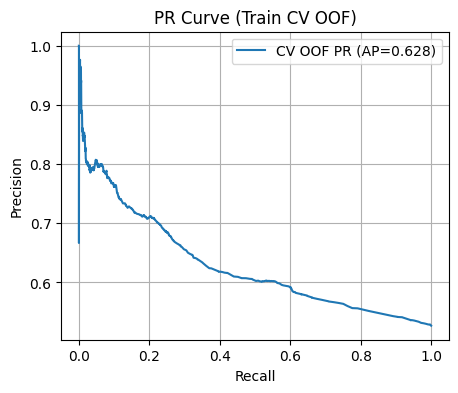

In [10]:
# 1) Build the tuned model to evaluate with CV (if you did GridSearchCV, use gs.best_estimator_)
tuned_model = model  # or: tuned_model = best_model from GridSearchCV

# 2) OOF probabilities on TRAIN (no test peeking)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
pred = cross_val_predict(
    tuned_model, X_train, y_train,
    cv=cv, method="predict_proba", n_jobs=-1
)[:, 1]

# 3) PR curve + AP on TRAIN (OOF)
prec, rec, thr = precision_recall_curve(y_train, pred)
ap = average_precision_score(y_train, pred)
print(f"CV (OOF) Average Precision: {ap:.3f}")

# 4) Choose threshold on TRAIN only (two options)
# A) Best F1
f1 = (2*prec*rec)/(prec+rec + 1e-9)
i = int(np.nanargmax(f1))
thr_best_f1 = float(thr[max(0, i-1)]) if len(thr) else 0.5
print("Chosen threshold (best F1 on CV OOF):", thr_best_f1)

plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"CV OOF PR (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve (Train CV OOF)")
plt.grid(True); plt.legend(); plt.show()

## Hyperparameter Tuning

In [12]:
param_grid = {
    "logisticregression__C": [0.05, 0.1, 0.5, 1, 2, 5, 10],     # strength of regularization
}

gs = GridSearchCV(
    estimator=model,                # your Pipeline(preprocess -> LR)
    param_grid=param_grid,
    scoring="average_precision",    # optimize AP
    cv=cv,
    n_jobs=-1,
    refit=True                      # refit best params on the full TRAIN split
)
gs.fit(X_train, y_train)


best_model = gs.best_estimator_
print("Best params:", gs.best_params_)
print("CV AP (best):", gs.best_score_)

Best params: {'logisticregression__C': 0.5}
CV AP (best): 0.6266469638824725


Test Average Precision=0.637
precision at threshold = 0.529
Recall at threshold = 0.529
F1 score at threshold = 0.529


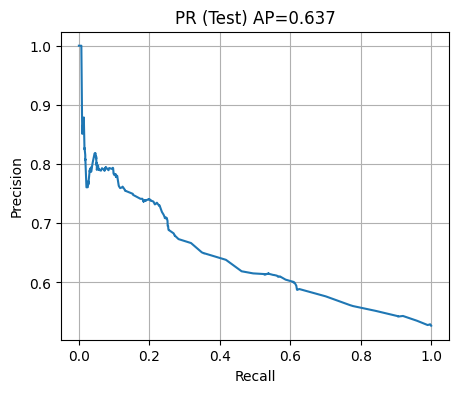

In [13]:
# Assume you have:
# best_model  -> tuned Pipeline (preprocess + LR)
# thr_best    -> fixed threshold chosen on TRAIN OOF (or your target-precision threshold)

# Refit on full TRAIN split
best_model.fit(X_train, y_train)

p_test = best_model.predict_proba(X_test)[:, 1]
test_ap   = average_precision_score(y_test, p_test)
test_prec = precision_score(y_test, p_test >= thr_best_f1, zero_division=0)
test_rec  = recall_score(y_test,  p_test >= thr_best_f1, zero_division=0)
test_f1   = f1_score(y_test,      p_test >= thr_best_f1, zero_division=0)

print(f"Test Average Precision={test_ap:.3f}")
print(f"precision at threshold = {test_prec:.3f}")
print(f"Recall at threshold = {test_prec:.3f}")
print(f"F1 score at threshold = {test_prec:.3f}")

prec_te, rec_te, _ = precision_recall_curve(y_test, p_test)
plt.figure(figsize=(5,4)); plt.plot(rec_te, prec_te)
plt.xlabel("Recall"); 
plt.ylabel("Precision")
plt.title(f"PR (Test) AP={test_ap:.3f}")
plt.grid(True); plt.show()


## Save artifacts to model_store/baseline_v1 and evals/

In [14]:
MODEL_TAG = "baseline_v2"  # bump each time you materially change features/model

# Where to store artifacts (works whether you run in repo root or /backend)
ROOT = Path.cwd()
if (ROOT/"backend").exists():
    MODEL_DIR = ROOT/"backend"/"model_store"/MODEL_TAG
    EVALS_DIR = ROOT/"evals"
else:
    MODEL_DIR = ROOT/"model_store"/MODEL_TAG
    EVALS_DIR = ROOT/"evals"

MODEL_DIR.mkdir(parents=True, exist_ok=True)
EVALS_DIR.mkdir(parents=True, exist_ok=True)

# 2.1 Save the entire sklearn Pipeline (preprocess + model)
joblib.dump(best_model, MODEL_DIR/"model.joblib")

# 2.2 Save the feature order expected at inference
(MODEL_DIR/"feature_names.json").write_text(json.dumps(FEATURES, indent=2))

# 2.3 Save metadata (threshold, training info)
(MODEL_DIR/"meta.json").write_text(json.dumps({
    "model_tag": MODEL_TAG,
    "trained_at": dt.datetime.utcnow().isoformat()+"Z",
    "algo": type(best_model.named_steps[list(best_model.named_steps.keys())[-1]]).__name__,  # e.g., LogisticRegression
    "threshold": float(thr_best_f1),
    "threshold_policy": "best_f1_on_train_oof",  # or "precision>=X on train OOF"
    "features_count": len(FEATURES),
    "sklearn_version": __import__("sklearn").__version__,
}, indent=2))

# 2.4 Save a tiny, human-readable eval snapshot for the repo
pd.DataFrame([{
    "model_tag": MODEL_TAG,
    "test_avg_precision": float(test_ap),
    "test_precision_at_thr": float(test_prec),
    "test_recall_at_thr": float(test_rec),
    "test_f1_at_thr": float(test_f1),
    "threshold": float(thr_best_f1),
    "n_test": int(len(y_test)),
}]).to_csv(EVALS_DIR/f"eval_{MODEL_TAG}.csv", index=False)

print("Saved artifacts to:", MODEL_DIR)
print("Saved eval CSV to  :", EVALS_DIR/f"eval_{MODEL_TAG}.csv")

Saved artifacts to: /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/model_store/baseline_v2
Saved eval CSV to  : /Users/paullevental/CodingWork/Course_Load_Risk/Course-Load-Risk/backend/training/evals/eval_baseline_v2.csv


/var/folders/z4/4803pm_d5gs3wzcdfkb6f1cw0000gn/T/ipykernel_59241/634808153.py:24: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at": dt.datetime.utcnow().isoformat()+"Z",


## Sanity checks: monotonic behavior wrt credits / past fails

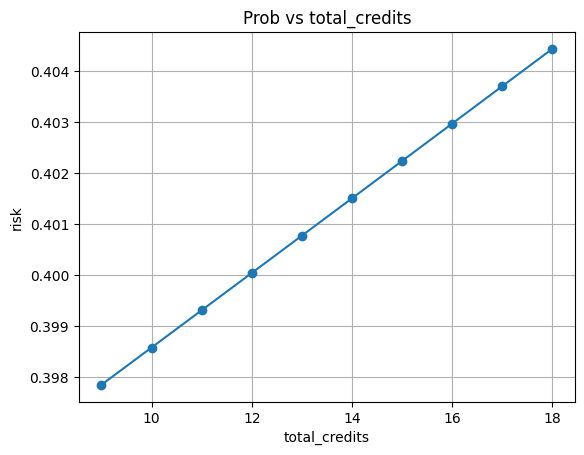

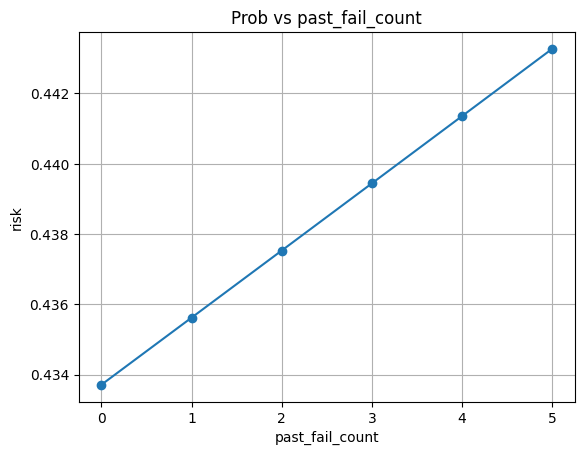

In [17]:
# Baseline at column medians
med = training_table[FEATURES].median(numeric_only=True)
base = med.to_dict()

def prob(d):
    # Ensure DataFrame with correct column order & names
    X = pd.DataFrame([d], columns=FEATURES)
    return float(best_model.predict_proba(X)[0, 1])

# Vary total_credits
credits_grid = list(range(9, 19))
p_credits = []
for c in credits_grid:
    d = base.copy()
    d['total_credits'] = c
    p_credits.append(prob(d))

# Vary past_fail_count
fails_grid = list(range(0, 6))
p_fails = []
for f in fails_grid:
    d = base.copy()
    d['past_fail_count'] = f
    p_fails.append(prob(d))

plt.figure()
plt.plot(credits_grid, p_credits, marker='o')
plt.title('Prob vs total_credits')
plt.xlabel('total_credits'); plt.ylabel('risk'); plt.grid(True); plt.show()

plt.figure()
plt.plot(fails_grid, p_fails, marker='o')
plt.title('Prob vs past_fail_count')
plt.xlabel('past_fail_count'); plt.ylabel('risk'); plt.grid(True); plt.show()